# Milestone Project 2: SkimLit 📄🔥

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

The paper we're replicating (the source of the dataset that we'll be using) is available here: https://arxiv.org/abs/1710.06071

And reading through the paper above, we see that the model architecture that they use to achieve their best results is available here: https://arxiv.org/abs/1612.05251

📖 **Resource:** If you want to find the ground truth for this notebook (with lots of diagrams and text annotations), see the GitHub: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/09_SkimLit_nlp_milestone_project_2.ipynb

## Confirm Access To A GPU:

In [1]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce GTX 1650 (UUID: GPU-8feeade6-0be8-8d5a-0dab-1e1fd2efb5f5)


## Get Data:

Source: https://github.com/Franck-Dernoncourt/pubmed-rct

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct
#You should see the following paths:
#PubMed_200k_RCT
#PubMed_200k_RCT_numbers_replaced_with_at_sign
#PubMed_20k_RCT
#PubMed_20k_RCT_numbers_replaced_with_at_sign
#README.md

Cloning into 'pubmed-rct'...
Updating files:  30% (4/13)
Updating files:  38% (5/13)
Updating files:  46% (6/13)
Updating files:  53% (7/13)
Updating files:  61% (8/13)
Updating files:  69% (9/13)
Updating files:  76% (10/13)
Updating files:  84% (11/13)
Updating files:  92% (12/13)
Updating files: 100% (13/13)
Updating files: 100% (13/13), done.
'ls' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
# Check what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/
#dev.txt   test.txt   train.txt
#"dev" oftem means a validation set

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [12]:
# Start our experiments using the 20k dataset with numbers replaced by "@" sign
data_dir = 'pubmed-rct/PubMed_20k_RCT/'

In [3]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT/dev.txt',
 'pubmed-rct/PubMed_20k_RCT/test.txt',
 'pubmed-rct/PubMed_20k_RCT/train.txt']

## Preprocess Data:

In [13]:
# Create function to read the lines of a document
def get_lines(filename):
    """
    Reads filename (a text filename) and returns the lines of text as a list.

    Args:
        filename: a string containing the target filepath.
    
        Returns:
            A list of strings with one string per line from the target filename.
    """
    with open(filename, 'r') as f:
        return f.readlines()

In [5]:
# Let's read in the training lines
train_lines = get_lines(data_dir + 'train.txt') # Read the lines within the training file
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of 6 weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at 12 weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of 125 patients with primary knee OA were randomized 1:1 ; 63 received 7.5 mg/day of prednisolone and 62 received placebo for 6 weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( 0-100 mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and 6-min walk distance ( 6MWD ) .\n',
 'METHODS\tSerum levels of interleukin 1 ( IL-1 ) , IL-6 , tumor necrosis factor ( TNF )

In [6]:
len(train_lines)

210040

```
[{'line_number': 0,
  'target': 'BACKGROUND',
  'text': 'Emotional eating is associated with overeating and the development of obesity .\n
  'total_lines': 11}.
 ...]
```

In [14]:
def preprocess_text_with_line_numbers(filename):
    """
    Returns a list of dictionaries of abstract line data.

    Takes in filename, reads its contents, and sorts through each line,
    extracting things like the target label, the text of the sentence,
    how many sentences are in the current abstract, and what sentence
    number the target line is.
    """
    input_lines = get_lines(filename) # Get all lines form filename
    abstract_lines = '' # Create an empty abstract
    abstract_samples = [] # Create an empty list of abstracts

    # Loop through each line in the target file
    for line in input_lines:
        if line.startswith('###'): # Check to see if the line is an ID line
            abstract_id = line
            abstract_lines = '' # Reset the abstract string if the line is an ID line
        
        elif line.isspace(): # Check to see if line is a new line
            abstract_line_split = abstract_lines.splitlines() # Split abstract into separate lines

            # Iterate through each line in a single abstract and count them at the same time
            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {} # Create an empty dictionary for each line
                target_text_split = abstract_line.split('\t') # Split target label from text
                line_data['target'] = target_text_split[0] # Get target label
                line_data['text'] = target_text_split[1].lower() # Get target text and lower it
                line_data['line_number'] = abstract_line_number # What numbe rline does the line appear in the abstract?
                line_data['total_lines'] = len(abstract_line_split) - 1 # How many total lines are there in the target abstract? (start form 0)
                abstract_samples.append(line_data) # Add line data to abstract samples list
        
        else: # If the above conditions aren't fulfilled, the line contains a labeled sentence
            abstract_lines += line
    
    return abstract_samples

In [15]:
# Get data form file and preprocess it
#%%time
train_samples = preprocess_text_with_line_numbers(data_dir + 'train.txt')
val_samples = preprocess_text_with_line_numbers(data_dir + 'dev.txt') # Dev is another name for validation dataset
test_samples = preprocess_text_with_line_numbers(data_dir + 'test.txt')
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135


In [9]:
# Check the first abstract of our training data
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of 6 weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at 12 weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of 125 patients with primary knee oa were randomized 1:1 ; 63 received 7.5 mg/day of prednisolone and 62 received placebo for 6 weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( 0-100 mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the weste

In [16]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of 6 weeks of dail...,0,11
1,METHODS,a total of 125 patients with primary knee oa w...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin 1 ( il-1 ) , il-6 ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( 9...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at 12 w...,9,11


In [11]:
# Distribution of labels in training data
train_df.target.value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

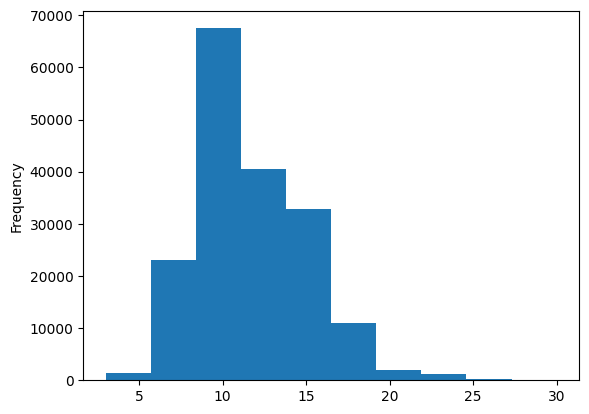

In [12]:
# Let's check the length of different lines
train_df.total_lines.plot.hist();

### Get List Of Sentences:

In [17]:
# Convert abstract text lines into lists
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [14]:
# View the first 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of 6 weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at 12 weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of 125 patients with primary knee oa were randomized 1:1 ; 63 received 7.5 mg/day of prednisolone and 62 received placebo for 6 weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( 0-100 mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and 6-min walk distance ( 6mwd ) .',
 'serum levels of interleukin 1 ( il-1 ) , il-6 , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was

## Make Numeric Labels:

In [18]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output = False) # We want non-sparse matrix
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1, 1))

# Check what one hot encoded labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], shape=(180040, 5))

### Label Encode Labels:

In [19]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.transform(test_df['target'].to_numpy())

# Check what the training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1], shape=(180040,))

In [9]:
# Get class names and number of classes form LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Starting A Series Of Modeling Experiments...

In [1]:
#Let's define functions to save/load a model and its corresponding history

import os
import pickle
import tensorflow as tf

def save_model_and_history(model, history, model_name, base_dir = "SkimLit_Models"):
    """
    Save a Keras model and its full History object to a subfolder.

    Args:
        model (tf.keras.Model): Trained Keras model to save.
        history (tf.keras.callbacks.History): History object from model.fit().
        model_name (str): Name for the model (used in filenames).
        base_dir (str): Directory where models are stored.
    """
    os.makedirs(base_dir, exist_ok=True)

    # Save model in .keras format
    model_path = os.path.join(base_dir, f"{model_name}.keras")
    model.save(model_path)

    # Save full History object
    history_path = os.path.join(base_dir, f"{model_name}_history.pkl")
    with open(history_path, "wb") as f:
        pickle.dump(history, f)

    print(f"✅ Saved model to {model_path}")
    print(f"✅ Saved full History object to {history_path}")


def load_model_and_history(model_name, base_dir = "SkimLit_Models"):
    """
    Reload a Keras model and its full History object.

    Returns:
        model (tf.keras.Model), history (tf.keras.callbacks.History)
    """
    model_path = os.path.join(base_dir, f"{model_name}.keras")
    history_path = os.path.join(base_dir, f"{model_name}_history.pkl")

    model = tf.keras.models.load_model(model_path)
    with open(history_path, "rb") as f:
        history = pickle.load(f)

    print(f"✅ Loaded model from {model_path}")
    print(f"✅ Loaded History object from {history_path}")
    return model, history

## Model 0 - Getting A Baseline:

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
    ('tf-idf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X = train_sentences,
            y = train_labels_encoded)

,steps,"[('tf-idf', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [20]:
# Save baseline model using joblib
from joblib import dump, load
from pathlib import Path
subfolder_path = Path('SkimLit_Models')
subfolder_path.mkdir(parents = True, exist_ok = True)
model_0_file_path = subfolder_path / 'model_0.joblib'
dump(model_0, model_0_file_path)

['SkimLit_Models\\model_0.joblib']

In [11]:
# Load baseline model using joblib
from joblib import dump, load
model_0 = load('Skimlit_Models/model_0.joblib')

In [21]:
# Evaluate baseline model on validation dataset
model_0.score(X = val_sentences,
                 y = val_labels_encoded)

0.7317291142592347

In [31]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([0, 1, 3, ..., 4, 4, 1], shape=(30212,))

In [23]:
val_labels_encoded

array([0, 0, 3, ..., 4, 1, 1], shape=(30212,))

### Download Helper Function Script:

Source: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py

In [24]:
!wget https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
from helper_functions import calculate_results

In [32]:
# Calculate baseline results
baseline_results = calculate_results(y_true = val_labels_encoded,
                                     y_pred = baseline_preds)
baseline_results

{'accuracy': 73.17291142592347,
 'precision': 0.7315166696974572,
 'recall': 0.7317291142592347,
 'f1': 0.7058060715307974}

In [33]:
# Save baseline results
import pickle
with open('SkimLit_Models/baseline_results.pkl', 'wb') as f:
    pickle.dump(baseline_results, f)

In [13]:
# Load baseline results
import pickle
with open('SkimLit_Models/baseline_results.pkl', 'rb') as f:
    baseline_results = pickle.load(f)

## Preparing Our Data (The Text) For Deep Sequence Models:

Before we start building deeper models, we've got to create vectorization and embedding layers.

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [13]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

np.float64(26.338435903132638)

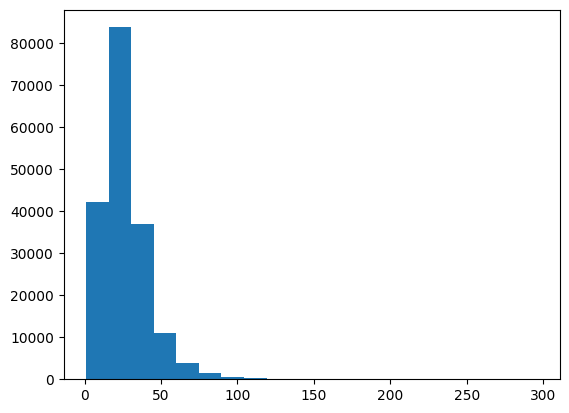

In [38]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins = 20);

In [14]:
# How long of a sentence length covers 95% of examples?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [40]:
# Maximum sequence length in the training set
max(sent_lens)

296

### Create Text Vectorizer Layer:

In [15]:
# How many words are in our vocab? (taken form table 2 in: https://arxiv.org/pdf/1710.06071)
max_tokens = 68000

In [16]:
# Create text vectorizer
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens = max_tokens, # Number of words in vocabulary
                                    output_sequence_length = output_seq_len) # Desired output length of vectorized sequences

In [17]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [18]:
# Test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f'Text:\n{target_sentence}')
print(f'\nLength of text: {len(target_sentence.split())}')
print(f'\nVectorized text: {text_vectorizer([target_sentence])}')

Text:
among medically managed acs patients < 75 years of age , the risk of ischemic outcomes was significantly reduced with prasugrel vs. clopidogrel among smokers vs. non-smokers .

Length of text: 28

Vectorized text: [[ 123 4900 2945 1978   12  466   69    4  107    2   75    4  828   77
    10   41  200    7 3573   45 1368  123  953   45 4958    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [19]:
# How many words in our training vocabulary?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f'Number of words in vocab: {len(rct_20k_text_vocab)}')
print(f'Most common words in the vocab: {rct_20k_text_vocab[:5]}')
print(f'Least common words in the vocab: {rct_20k_text_vocab[-5:]}')

Number of words in vocab: 68000
Most common words in the vocab: ['', '[UNK]', np.str_('the'), np.str_('and'), np.str_('of')]
Least common words in the vocab: [np.str_('httpsuploaduminacjpcgiopenbinctrctrcgifunctionbrowsactionbrowstypesummaryrecptnor000008238languagee'), np.str_('httpsregisterclinicaltrialsgov'), np.str_('httpsmartmicrosurgerycom'), np.str_('httpseudractemaeuropaeuindexhtml'), np.str_('httpseudractemaeuropaeu')]


In [48]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 68000}

### Create Custom Text Embedding:

In [20]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim = len(rct_20k_text_vocab), # Length of vocabulary
                               output_dim = 128, # Note: different embedidng sizes result in drastically different numbers of parameters to train
                               mask_zero = True, # Use masking to handle variable sequence lengths (save space)
                               name = 'token_embedding')

In [50]:
# Show example embedding
print(f'Sentence before vectorization:\n {target_sentence}\n')
vectorized_sentence = text_vectorizer([target_sentence])
print(f'Sentence after vectorization (before embedding)\n {vectorized_sentence}\n')
embedded_sentence = token_embed(vectorized_sentence)
print(f'Sentence after embedding:\n {embedded_sentence}\n')
print(f'Embedded sentence shape: {embedded_sentence.shape}')

Sentence before vectorization:
 in patients with nste-acs , benefit of ticagrelor over clopidogrel in reducing ischaemic events and total mortality was consistent with the overall plato trial , independent of actually performed revascularization during the initial 10 days .

Sentence after vectorization (before embedding)
 [[   5   12    7 8732  426    4 2436  156 1368    5  493 3696  131    3
    79  271   10  988    7    2  197 9388   33  603    4 6598  165 1529
    54    2  515  111   93    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding:
 [[[ 0.02142573 -0.01800411  0.04422295 ...  0.04391423 -0.02957952
    0.03061524]
  [ 0.01923646  0.00354381  0.0190185  ...  0.03886775  0.00509398
    0.03052169]
  [-0.03002423  0.03240845  0.00137496 ... -0.00927222 -0.01036156
    0.04024344]
  ...
  [-0.04054984 -0.01681764 -0.03605659 ... -0.03467177  0.03128153
   -0.00176967]
  [-0.04054984 -0.016817

## Creating Datasets:

In [23]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [24]:
# Take the TensorSliceDatasets and turn them into prefetched datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1 - Conv1D With Token Embeddings:

In [60]:
# Create 1D conv model to process sequences
inputs = layers.Input(shape = (1,), dtype = tf.string)
text_vectors = text_vectorizer(inputs) # Vectorize text inputs
token_embeddings = token_embed(text_vectors) # Create embedding
x = layers.Conv1D(64, kernel_size = 5, padding = 'same', activation = 'relu')(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # Condense the output of our feature vector from conv layer
outputs = layers.Dense(num_classes, activation = 'softmax')(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

c:\Users\Jake\Documents\Udemy_Courses\.venv\Lib\site-packages\keras\src\layers\layer.py:970: UserWarning: Layer 'conv1d_1' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [61]:
model_1.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 55)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_embedding (Embedding)     │ (None, 55, 128)        │     8,704,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 55, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,745,349 (33.36 MB)

 Trainable params: 8,745,349 (33.36 MB)

 Non-trainable params: 0 (0.00 B)

In [62]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch = int(0.1 * len(train_dataset)),
                              epochs = 3,
                              validation_data = valid_dataset,
                              validation_steps = int(0.1 * len(valid_dataset))) # Only validate on 10% of batches

Epoch 1/3


c:\Users\Jake\Documents\Udemy_Courses\.venv\Lib\site-packages\keras\src\layers\layer.py:970: UserWarning: Layer 'conv1d_1' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


562/562 ━━━━━━━━━━━━━━━━━━━━ 162s 280ms/step - accuracy: 0.6384 - loss: 0.9112 - val_accuracy: 0.7443 - val_loss: 0.6823
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 111s 198ms/step - accuracy: 0.7587 - loss: 0.6500 - val_accuracy: 0.7736 - val_loss: 0.6196
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 192s 342ms/step - accuracy: 0.7791 - loss: 0.6066 - val_accuracy: 0.7856 - val_loss: 0.5893


In [63]:
# Save model and its history
save_model_and_history(model_1, history_model_1, 'model_1')

✅ Saved model to SkimLit_Models\model_1.keras
✅ Saved full History object to SkimLit_Models\model_1_history.pkl


In [25]:
# Load model and its history
model_1, history_model_1 = load_model_and_history('model_1')

c:\Users\Jake\Documents\Udemy_Courses\.venv\Lib\site-packages\keras\src\layers\layer.py:970: UserWarning: Layer 'conv1d_1' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


✅ Loaded model from SkimLit_Models\model_1.keras
✅ Loaded History object from SkimLit_Models\model_1_history.pkl


In [67]:
# Evaluate on whole validation dataset
model_1.evaluate(valid_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.7904 - loss: 0.5860


[0.5859518051147461, 0.7903813123703003]

In [68]:
# Make predictions (our model predicts prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

945/945 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step


(array([[4.69712347e-01, 1.06281698e-01, 7.59072825e-02, 3.17936778e-01,
         3.01618669e-02],
        [4.67656225e-01, 2.35992625e-01, 1.17313275e-02, 2.73637265e-01,
         1.09825833e-02],
        [1.71483770e-01, 4.14260104e-03, 1.15835608e-03, 8.23155642e-01,
         5.95955571e-05],
        ...,
        [4.70833669e-07, 6.81004094e-05, 8.13091348e-04, 1.93222377e-07,
         9.99118149e-01],
        [1.67291928e-02, 3.78404558e-01, 7.91450068e-02, 1.61295384e-02,
         5.09591699e-01],
        [2.42408246e-01, 4.96067584e-01, 9.68498662e-02, 7.24443942e-02,
         9.22299623e-02]], shape=(30212, 5), dtype=float32),
 (30212, 5))

In [69]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis = 1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1], shape=(30212,))>

In [70]:
# Calculate model_1 results
model_1_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_1_preds)
model_1_results

{'accuracy': 79.03813054415464,
 'precision': 0.7849626575943286,
 'recall': 0.7903813054415464,
 'f1': 0.7867378179656259}

In [72]:
# Save model_1 results
import pickle
with open('SkimLit_Models/model_1_results.pkl', 'wb') as f:
    pickle.dump(model_1_results, f)

In [26]:
# Load model_1 results
import pickle
with open('SkimLit_Models/model_1_results.pkl', 'rb') as f:
    model_1_results = pickle.load(f)

In [74]:
baseline_results

{'accuracy': 73.17291142592347,
 'precision': 0.7315166696974572,
 'recall': 0.7317291142592347,
 'f1': 0.7058060715307974}

## Model 2 - Feature Extraction With Pretrained Token Embeddings:

Uiversal Sntence Ecoder (USE) Source: https://www.kaggle.com/models/google/universal-sentence-encoder/tensorFlow2/universal-sentence-encoder

In [21]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer('https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2',
                                        trainable = False,
                                        name = 'universal_sentence_encoder')

In [22]:
# Test out the pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f'Random sentence\n {random_train_sentence}')
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f'Sentence after embedding:\n{use_embedded_sentence[0][:30]}\n')
print(f'Length of sentence embedding: {len(use_embedded_sentence[0])}')

Random sentence
 patients with inflammation respond less well to treatment with erythropoietin , possibly because the increased production of hepcidin reduces the availability of iron for hematopoiesis .



Sentence after embedding:
[-0.00100466  0.00118682  0.02251403 -0.07868419 -0.01835541  0.04984711
 -0.01092721 -0.07538962  0.04916417 -0.03099833  0.08960873  0.02283462
  0.06840616  0.02562522  0.03136013 -0.01579741 -0.09037247  0.01095491
  0.00076019  0.01213971 -0.04535933  0.04332899 -0.02785781 -0.0269786
  0.04835008 -0.01488334  0.00292901 -0.06446439 -0.00636593  0.01356315]

Length of sentence embedding: 512


## Building And Fitting An NLP Feature Extraction Model Using Pretrained Embeddings From TensorFlow Hub

In [23]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from keras.saving import register_keras_serializable

@register_keras_serializable(package="Custom", name="HubTextEncoder")
class HubTextEncoder(layers.Layer):
    def __init__(self, hub_url, trainable=False, **kwargs):
        super().__init__(**kwargs)
        self.hub_url = hub_url
        self.trainable_flag = trainable
        self.hub_layer = hub.KerasLayer(self.hub_url, trainable=self.trainable_flag)

    def call(self, inputs):
        return self.hub_layer(inputs)

    def get_config(self):
        config = super().get_config()
        config.update({
            "hub_url": self.hub_url,
            "trainable": self.trainable_flag,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


def create_text_model(model_url, num_classes=num_classes, activation="softmax"):
    # Text input: scalar string tensor
    inputs = tf.keras.Input(shape=(), dtype=tf.string, name="text_input")
    x = HubTextEncoder(model_url, trainable=False, name="text_embedding_layer")(inputs)
    x = layers.Dense(128, activation="relu", name="hidden_dense")(x)
    outputs = layers.Dense(num_classes, activation=activation, name="output_layer")(x)
    return tf.keras.Model(inputs=inputs, outputs=outputs, name="hub_text_model")


In [81]:
# Execute the above functions to create model_2
model_url = "https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2"
model_2 = create_text_model(model_url, num_classes=num_classes, activation="softmax")

model_2.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

model_2.summary()

Model: "hub_text_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)         │ (None)                 │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_embedding_layer            │ (None, 512)            │             0 │
│ (HubTextEncoder)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_dense (Dense)            │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,309 (259.02 KB)

 Trainable params: 66,309 (259.02 KB)

 Non-trainable params: 0 (0.00 B)

In [82]:
# Fit model_2 to the data
history_model_2 = model_2.fit(train_dataset,
                              epochs = 3,
                              steps_per_epoch = int(0.1 * len(train_dataset)),
                              validation_data = valid_dataset,
                              validation_steps = int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.6336 - loss: 0.3310 - val_accuracy: 0.6912 - val_loss: 0.2779
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - accuracy: 0.7063 - loss: 0.2645 - val_accuracy: 0.7138 - val_loss: 0.2606
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 45s 80ms/step - accuracy: 0.7189 - loss: 0.2561 - val_accuracy: 0.7191 - val_loss: 0.2552


In [83]:
# Save model and its history
save_model_and_history(model_2, history_model_2, 'model_2')

✅ Saved model to SkimLit_Models\model_2.keras
✅ Saved full History object to SkimLit_Models\model_2_history.pkl


In [30]:
# Load model and its history
model_2, history_model_2 = load_model_and_history('model_2')

✅ Loaded model from SkimLit_Models\model_2.keras
✅ Loaded History object from SkimLit_Models\model_2_history.pkl


In [85]:
# Evaluate on the whole validation dataset
model_2.evaluate(valid_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 84s 86ms/step - accuracy: 0.7241 - loss: 0.2518


[0.25184381008148193, 0.7240500450134277]

In [86]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 30s 30ms/step


array([[4.6164635e-01, 3.6206222e-01, 1.1321725e-03, 1.6047154e-01,
        1.4687713e-02],
       [2.9574022e-01, 6.0862923e-01, 7.3822285e-04, 9.2736349e-02,
        2.1559070e-03],
       [1.4096348e-01, 1.6080213e-01, 8.7069254e-03, 6.7995268e-01,
        9.5748277e-03],
       ...,
       [7.1377835e-05, 1.7441630e-04, 4.2737271e-03, 5.6766123e-05,
        9.9542373e-01],
       [1.5319963e-03, 9.9200411e-03, 1.1127627e-01, 5.0974579e-04,
        8.7676191e-01],
       [1.7855865e-01, 1.4698541e-01, 6.5435243e-01, 3.2139239e-03,
        1.6889613e-02]], shape=(30212, 5), dtype=float32)

In [87]:
# Convert the prediction probabilities found with feature extraction model to labels
model_2_preds = tf.argmax(model_2_pred_probs, axis = 1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2], shape=(30212,))>

In [88]:
# Calculate results from TF Hub pretrained embeddings results on val set
model_2_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_2_preds)
model_2_results

{'accuracy': 72.4050046339203,
 'precision': 0.7232292641448071,
 'recall': 0.724050046339203,
 'f1': 0.7195775743951376}

In [89]:
baseline_results

{'accuracy': 73.17291142592347,
 'precision': 0.7315166696974572,
 'recall': 0.7317291142592347,
 'f1': 0.7058060715307974}

In [90]:
model_1_results

{'accuracy': 79.03813054415464,
 'precision': 0.7849626575943286,
 'recall': 0.7903813054415464,
 'f1': 0.7867378179656259}

In [91]:
# Save model_2 results
import pickle
with open('SkimLit_Models/model_2_results.pkl', 'wb') as f:
    pickle.dump(model_2_results, f)

In [31]:
# Load model_2 results
import pickle
with open('SkimLit_Models/model_2_results.pkl', 'rb') as f:
    model_2_results = pickle.load(f)

## Model 3 - Conv1D With Character Embeddings:

### Creating A Character-Level Tokenizer:

In [93]:
train_sentences[:5]

['to investigate the efficacy of 6 weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at 12 weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of 125 patients with primary knee oa were randomized 1:1 ; 63 received 7.5 mg/day of prednisolone and 62 received placebo for 6 weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( 0-100 mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and 6-min walk distance ( 6mwd ) .']

In [24]:
# Make function to split sentences into characters
def split_chars(text):
    return ' '.join(list(text))

# Text splitting non-character level sequence into characters
split_chars(random_train_sentence)

'p a t i e n t s   w i t h   i n f l a m m a t i o n   r e s p o n d   l e s s   w e l l   t o   t r e a t m e n t   w i t h   e r y t h r o p o i e t i n   ,   p o s s i b l y   b e c a u s e   t h e   i n c r e a s e d   p r o d u c t i o n   o f   h e p c i d i n   r e d u c e s   t h e   a v a i l a b i l i t y   o f   i r o n   f o r   h e m a t o p o i e s i s   .'

In [25]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   6   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   1 2   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   1 2 5   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   1 : 1   ;   6 3   r e c e i v e d   7 . 5   m g / d a y   o f   p r e d n i s o l o n e   a n d   6 2   r e c e i v e d   p l a c e b o   f o r   6   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s 

In [26]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

np.float64(152.006276383026)

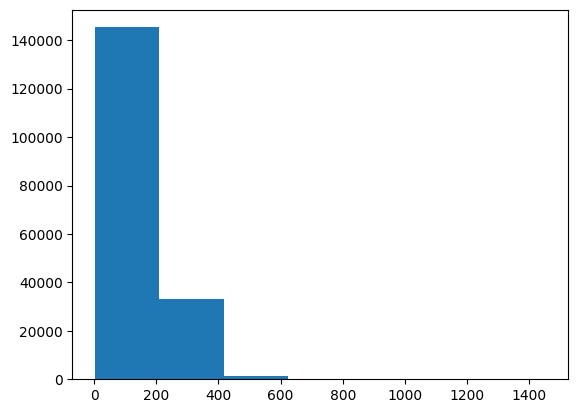

In [36]:
# Check the distribution of our sequences at a character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins = 7);

In [27]:
# Find what characte length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

296

In [28]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [29]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # Add 2 for space and OOV token (OOO = out of vocab, '[UNK]')
char_vectorizer = TextVectorization(max_tokens = NUM_CHAR_TOKENS,
                                    output_sequence_length = output_seq_char_len,
                                    standardize = 'lower_and_strip_punctuation', # Set standardization to "None" if you want to leave punctuation in
                                    name = 'char_vectorizer')

In [30]:
# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [31]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f'Number of different characters in character vocab: {len(char_vocab)}')
print(f'5 most common characters: {char_vocab[:5]}')
print(f'5 least common characters: {char_vocab[-5:]}')

Number of different characters in character vocab: 38
5 most common characters: ['', '[UNK]', np.str_('e'), np.str_('t'), np.str_('i')]
5 least common characters: [np.str_('8'), np.str_('7'), np.str_('z'), np.str_('q'), np.str_('j')]


In [32]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f'Charified text:\n {random_train_chars}')
print(f'\nLength of random_train_chars: {len(random_train_chars.split())}')
vectorized_chars = char_vectorizer([random_train_chars])
print(f'\nVectorized chars\n {vectorized_chars}')
print(f'\nLength of vectorized chars: {len(vectorized_chars[0])}')

Charified text:
 a n o n y m i z e d   s a m p l e s   w e r e   r e p r e s e n t a t i v e   o f   t h e   u s   b l o o d   d o n o r   p o p u l a t i o n   (   n   =   5 0 0 0   )   ,   h e a l t h y   u k   d o n o r s   (   n   =   2 0 0   )   ,   p a t i e n t s   w i t h   n o n p r i o n   n e u r o d e g e n e r a t i v e   d i s e a s e s   (   n   =   3 5 2   )   ,   p a t i e n t s   i n   w h o m   a   p r i o n   d i s e a s e   d i a g n o s i s   w a s   l i k e l y   (   n   =   1 0 5   )   ,   a n d   p a t i e n t s   w i t h   c o n f i r m e d   v c j d   (   n   =   1 0   )   .

Length of random_train_chars: 235

Vectorized chars
 [[ 5  6  7  6 19 15  4 35  2 10  9  5 15 14 12  2  9 20  2  8  2  8  2 14
   8  2  9  2  6  3  5  3  4 21  2  7 17  3 13  2 16  9 22 12  7  7 10 10
   7  6  7  8 14  7 14 16 12  5  3  4  7  6  6 26 23 23 23 13  2  5 12  3
  13 19 16 27 10  7  6  7  8  9  6 25 23 23 14  5  3  4  2  6  3  9 20  4
   3 13  6  7  6 14  8  4  7  6  6  2 16 

## Creating A Character-Level Embedding:

In [33]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim = len(char_vocab), # Number of different characters
                              output_dim = 25, # This is the size of the char embedding in the paper: https://arxiv.org/pdf/1612.05251.pdf (Figure 1)
                              mask_zero = True,
                              name = 'char_embed')

In [34]:
# Test our character embedding layer
print(f'Charified text:\n {random_train_chars}\n')
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f'Embedded chars (after vectorization and embedding)\n {char_embed_example}\n')
print(f'Characted embedding shape: {char_embed_example.shape}')

Charified text:
 a n o n y m i z e d   s a m p l e s   w e r e   r e p r e s e n t a t i v e   o f   t h e   u s   b l o o d   d o n o r   p o p u l a t i o n   (   n   =   5 0 0 0   )   ,   h e a l t h y   u k   d o n o r s   (   n   =   2 0 0   )   ,   p a t i e n t s   w i t h   n o n p r i o n   n e u r o d e g e n e r a t i v e   d i s e a s e s   (   n   =   3 5 2   )   ,   p a t i e n t s   i n   w h o m   a   p r i o n   d i s e a s e   d i a g n o s i s   w a s   l i k e l y   (   n   =   1 0 5   )   ,   a n d   p a t i e n t s   w i t h   c o n f i r m e d   v c j d   (   n   =   1 0   )   .

Embedded chars (after vectorization and embedding)
 [[[ 7.5229034e-03  3.0357946e-02 -3.5580277e-02 ...  1.0761928e-02
   -4.6356346e-02 -4.4692397e-02]
  [-3.4584127e-02  3.6168072e-02  4.1322496e-02 ...  2.8411854e-02
   -7.7384003e-03  4.2101551e-02]
  [ 1.3730675e-04  4.8330221e-02 -3.7610531e-05 ...  3.5561547e-03
   -2.8812766e-02 -2.4708057e-02]
  ...
  [ 3.9007436e-02  3.3876523e

## Building A Conv1D Model To Fit On Character Embeddings:

In [60]:
# Make Conv1D on chars only
inputs = layers.Input(shape = (1,), dtype = 'string')
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size = 5, padding = 'same', activation = 'relu')(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation = 'softmax')(x)
model_3 = tf.keras.Model(inputs = inputs,
                         outputs = outputs,
                         name = 'model_3_conv1d_char_embeddings')

# Compile
model_3.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

c:\Users\Jake\Documents\Udemy_Courses\.venv\Lib\site-packages\keras\src\layers\layer.py:970: UserWarning: Layer 'conv1d_1' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [61]:
# Summary
model_3.summary()

Model: "model_3_conv1d_char_embeddings"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ char_vectorizer                 │ (None, 296)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ char_embed (Embedding)          │ (None, 296, 25)        │           950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 296, 64)        │         8,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,339 (36.48 KB)

 Trainable params: 9,339 (36.48 KB)

 Non-trainable params: 0 (0.00 B)

In [58]:
# Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [62]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch = int(0.1 * len(train_char_dataset)),
                              epochs = 3,
                              validation_data = val_char_dataset,
                              validation_steps = int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 54s 93ms/step - accuracy: 0.5187 - loss: 1.1883 - val_accuracy: 0.5778 - val_loss: 1.0554
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 82s 146ms/step - accuracy: 0.5910 - loss: 1.0124 - val_accuracy: 0.6300 - val_loss: 0.9557
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 60s 106ms/step - accuracy: 0.6255 - loss: 0.9444 - val_accuracy: 0.6493 - val_loss: 0.8978


In [63]:
# Save model and its history
save_model_and_history(model_3, model_3_history, 'model_3')

✅ Saved model to SkimLit_Models\model_3.keras
✅ Saved full History object to SkimLit_Models\model_3_history.pkl


In [43]:
# Load model and its history
model_3, model_3_history = load_model_and_history('model_3')

✅ Loaded model from SkimLit_Models\model_3.keras
✅ Loaded History object from SkimLit_Models\model_3_history.pkl


In [65]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step


array([[0.15636204, 0.3619727 , 0.11918502, 0.30501854, 0.05746169],
       [0.10582199, 0.23801956, 0.06816705, 0.26908693, 0.3189045 ],
       [0.09011256, 0.16236362, 0.29624897, 0.32248732, 0.12878753],
       ...,
       [0.00974523, 0.01926547, 0.09098357, 0.00792104, 0.8720846 ],
       [0.01863162, 0.0396384 , 0.47258416, 0.04257193, 0.42657393],
       [0.30835164, 0.3856126 , 0.19498172, 0.0538378 , 0.05721627]],
      shape=(30212, 5), dtype=float32)

In [66]:
# Convert prediction probabilities to class labels
model_3_preds = tf.argmax(model_3_pred_probs, axis = 1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 4, 3, ..., 4, 2, 1], shape=(30212,))>

In [67]:
# Calculate results for Conv1D model chars only
model_3_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_3_preds)
model_3_results

{'accuracy': 64.35191314709388,
 'precision': 0.6519420774973604,
 'recall': 0.6435191314709388,
 'f1': 0.6272081454332413}

In [68]:
baseline_results

{'accuracy': 73.17291142592347,
 'precision': 0.7315166696974572,
 'recall': 0.7317291142592347,
 'f1': 0.7058060715307974}

In [69]:
# Save model_3 results
import pickle
with open('SkimLit_Models/model_3_results.pkl', 'wb') as f:
    pickle.dump(model_3_results, f)

In [44]:
# Load model_3 results
import pickle
with open('SkimLit_Models/model_3_results.pkl', 'rb') as f:
    model_3_results = pickle.load(f)

## Model 4 - Combining Pretrained Token Embeddings + Characters Embeddings (Hybrid Embedding Layer):

1. Create a token-level embedding model (similar to `model_1`)
2. Create a character-level model (similar to `model_3` with a slight modification)
3. Combine 1 & 2 with a comcatenate (`layers.Concatenate`)
4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of https://arxiv.org/pdf/1612.05251.pdf
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output

To make using tf hub models easier, a generic wrapper class has been added to helper_functions.py.

In [4]:
from helper_functions import HubFeatureExtractor

In [46]:
# 1. Set up token inputs/model
token_inputs = layers.Input(shape = [], dtype = tf.string, name = 'token_input')
token_embeddings = HubFeatureExtractor('https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2', trainable = False)(token_inputs)
token_outputs = layers.Dense(128, activation = 'relu')(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs,
                             outputs = token_outputs)

# 2. Set up char inputs/model
char_inputs = layers.Input(shape = (1, ), dtype = tf.string, name = 'char_input')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) # Bi-LSTm shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs = char_inputs,
                            outputs = char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name = 'token_char_hybrid')([token_model.output,
                                                                    char_model.output])

# 4. Create output layers - adding in Dropout, discussed in section 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation = 'relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation = 'softmax')(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs = [token_model.input, char_model.input],
                         outputs = output_layer,
                         name = 'model_4_token_and_char_embeddings')

In [47]:
# Get a summary of our model
model_4.summary()

Model: "model_4_token_and_char_embeddings"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ char_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_input         │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_vectorizer     │ (None, 296)       │          0 │ char_input[0][0]  │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hub_feature_extrac… │ (None, 512)       │          0 │ token_input[0][0] │
│ (HubFeatureExtract… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_embed          │ (None, 296, 25)   │        950 │ char_vectorizer[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_4         │ (None, 296)       │          0 │ char_vectorizer[… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     65,664 │ hub_feature_extr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 48)        │      9,600 │ char_embed[0][0], │
│ (Bidirectional)     │                   │            │ not_equal_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_char_hybrid   │ (None, 176)       │          0 │ dense[0][0],      │
│ (Concatenate)       │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 176)       │          0 │ token_char_hybri… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     22,656 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 5)         │        645 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 99,515 (388.73 KB)

 Trainable params: 99,515 (388.73 KB)

 Non-trainable params: 0 (0.00 B)

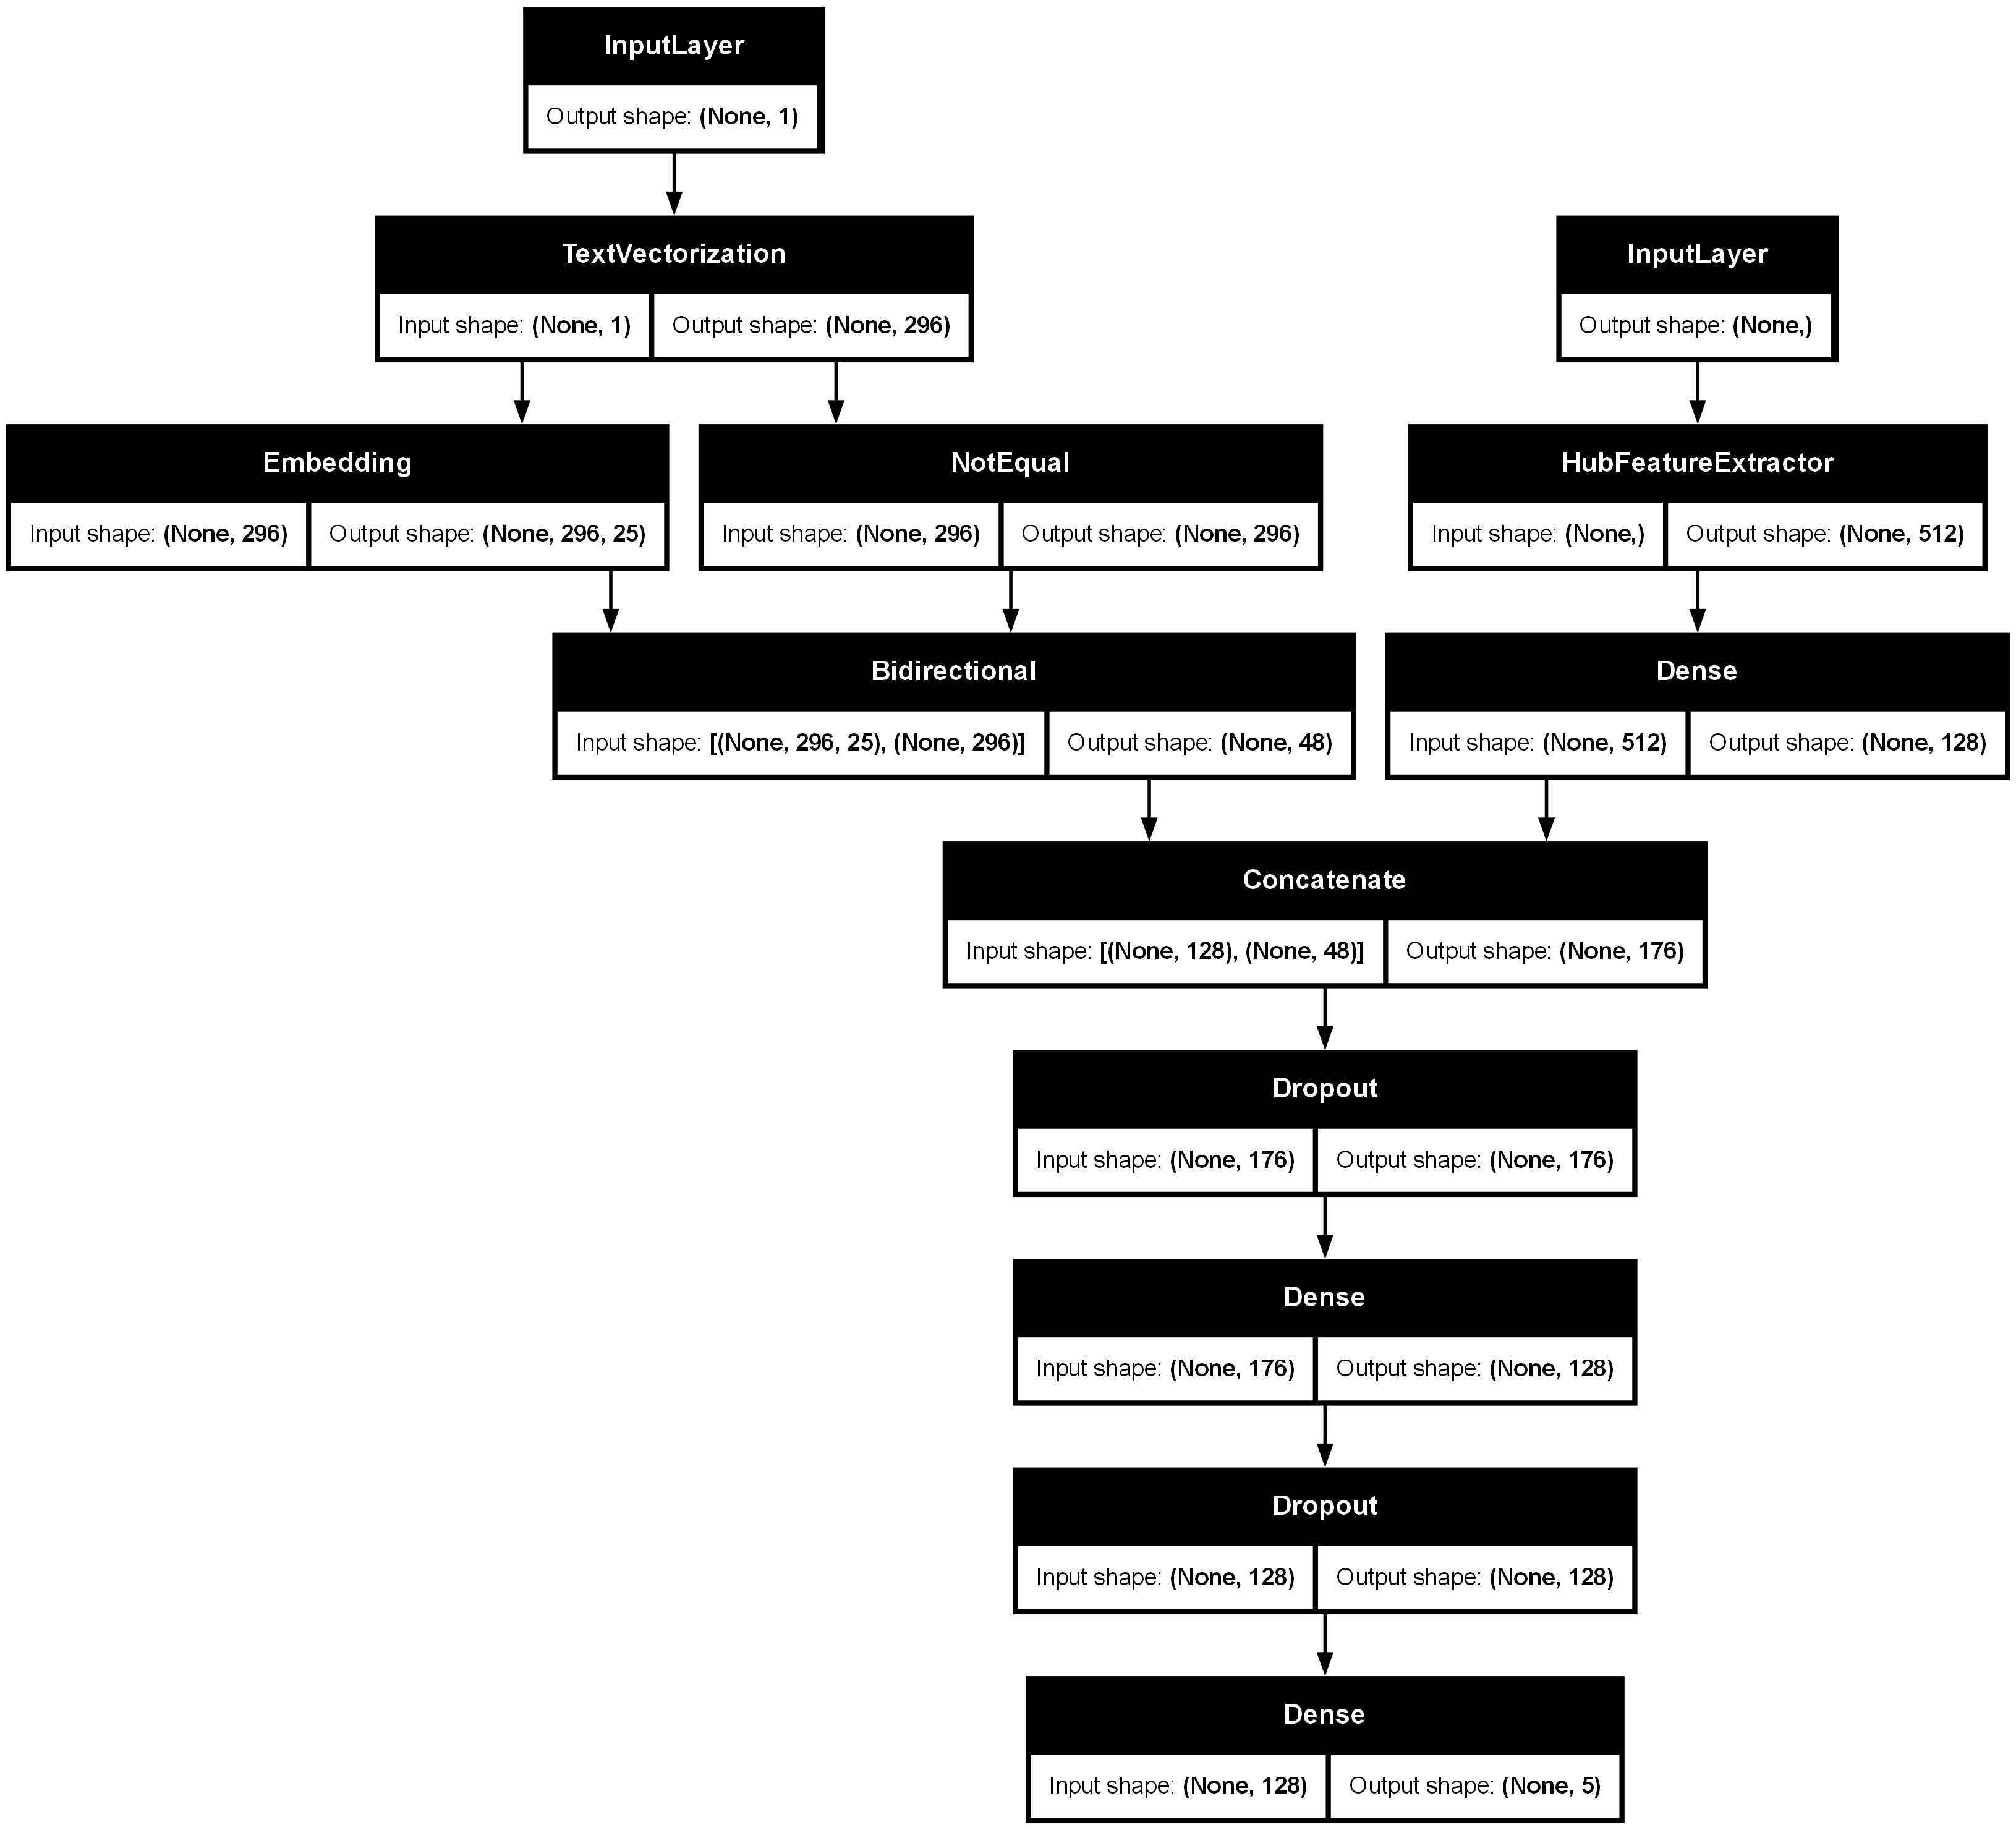

In [49]:
# Ploy hybrid token and character model
from keras.utils import plot_model
plot_model(model_4, show_shapes = True)

In [50]:
# Compile token char model
model_4.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(), # Section 4.2 of the paper says they use SGD; you might want to try this
                metrics = ['accuracy'])

### Combining Token And Character Data Into A tf.data Dataset:

In [51]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # Make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # Make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # Combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [52]:
# Repeat the above steps for our validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars)) # Make data
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot) # Make labels
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels)) # Combine data and labels
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [53]:
# Check out our training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fiting A Model On Token And Character-Level Sequences:

In [54]:
# Fit the model on tokens and chars
history_model_4 = model_4.fit(train_char_token_dataset,
                              steps_per_epoch = int(0.1 * len(train_char_token_dataset)),
                              epochs = 3,
                              validation_data = val_char_token_dataset,
                              validation_steps = int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 516s 821ms/step - accuracy: 0.6200 - loss: 0.9573 - val_accuracy: 0.7025 - val_loss: 0.7690
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 246s 437ms/step - accuracy: 0.7000 - loss: 0.7788 - val_accuracy: 0.7291 - val_loss: 0.7105
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 323s 575ms/step - accuracy: 0.7122 - loss: 0.7510 - val_accuracy: 0.7457 - val_loss: 0.6811


In [55]:
# Save model_4 and its history
save_model_and_history(model_4, history_model_4, 'model_4')

✅ Saved model to SkimLit_Models\model_4.keras
✅ Saved full History object to SkimLit_Models\model_4_history.pkl


In [46]:
# Load model_4 and its history
model_4, history_model_4 = load_model_and_history('model_4')

✅ Loaded model from SkimLit_Models\model_4.keras
✅ Loaded History object from SkimLit_Models\model_4_history.pkl


In [57]:
# Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 88s 90ms/step - accuracy: 0.7423 - loss: 0.6790


[0.67899090051651, 0.7422547340393066]

In [58]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 88s 91ms/step


array([[4.0143847e-01, 3.3581352e-01, 5.8562891e-03, 2.4812722e-01,
        8.7644178e-03],
       [3.4976298e-01, 4.3928978e-01, 3.2494534e-03, 2.0595554e-01,
        1.7423028e-03],
       [2.7756682e-01, 9.7464845e-02, 1.6626477e-02, 5.9861392e-01,
        9.7279968e-03],
       ...,
       [1.3012707e-04, 1.5197865e-03, 4.5490824e-02, 2.2506845e-05,
        9.5283675e-01],
       [6.3439785e-03, 3.9100837e-02, 3.1870833e-01, 3.3362978e-03,
        6.3251060e-01],
       [4.8171487e-01, 2.9640341e-01, 1.7589012e-01, 2.9229216e-02,
        1.6762394e-02]], shape=(30212, 5), dtype=float32)

In [59]:
# Format pred probs into pred labels
model_4_preds = tf.argmax(model_4_pred_probs, axis = 1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 0], shape=(30212,))>

In [60]:
# Get results of token-char-hybrid model
model_4_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_4_preds)
model_4_results

{'accuracy': 74.22547332185886,
 'precision': 0.7453455956008004,
 'recall': 0.7422547332185886,
 'f1': 0.7402384328463105}

In [61]:
model_1_results

{'accuracy': 79.03813054415464,
 'precision': 0.7849626575943286,
 'recall': 0.7903813054415464,
 'f1': 0.7867378179656259}

In [62]:
# Save model_4 results
import pickle
with open('SkimLit_Models/model_4_results.pkl', 'wb') as f:
    pickle.dump(model_4_results, f)

In [47]:
# Load model_4 results
import pickle
with open('SkimLit_Models/model_4_results.pkl', 'rb') as f:
    model_4_results = pickle.load(f)

## Model 5 - Transfer Learning With Pretrained Token Embeddings + Character Embeddings + Positional Embeddings:

In [49]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of 6 weeks of dail...,0,11
1,METHODS,a total of 125 patients with primary knee oa w...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


### Create Positional Embeddings:

In [51]:
# How many different line numbers are there?
train_df['line_number'].value_counts()

line_number
0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

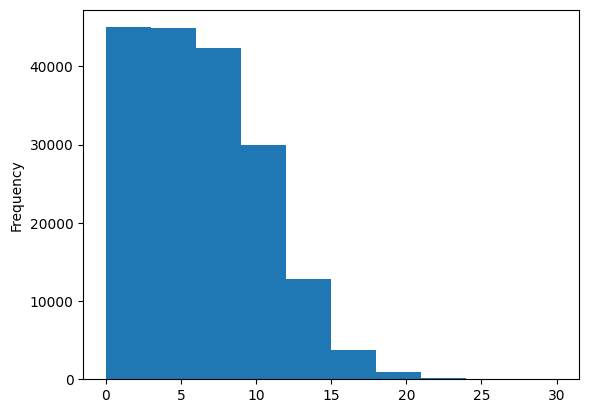

In [52]:
# Check the distribution of 'line_number' column
train_df.line_number.plot.hist()

In [36]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth = 15)
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth = 15)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth = 15)
train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 15]))

In [55]:
# How many different numbers of lines are there?
train_df['total_lines'].value_counts()

total_lines
11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: count, dtype: int64

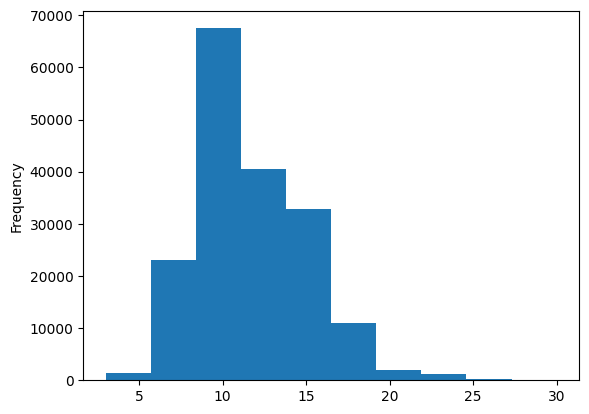

In [56]:
# Check the distributions of total lines
train_df.total_lines.plot.hist();

In [58]:
# Check the coverage of a "total_lines" value of 20
np.percentile(train_df.total_lines, 98)

np.float64(20.0)

In [37]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" feature
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth = 20)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(), depth = 20)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth = 20)
train_total_lines_one_hot, train_total_lines_one_hot.shape

(<tf.Tensor: shape=(180040, 20), dtype=float32, numpy=
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], shape=(180040, 20), dtype=float32)>,
 TensorShape([180040, 20]))

### Building a Tribrid Embedding Model:

1. Create a token-level model
2. Create a character-level model
3. Create a model for the "line_number" feature
4. Create a model for the "total_lines" feature
5. Combine the outputs of 1 & 2 using tf.keras.layers.Concatenate
6. Combine the outputs of 3, 4, & 5 using tf.keras.layers.Concatenate
7. Create an output layer to accept the tribrid embedding and output label probabilities
8. Combine the inputs of 1, 2, 3, & 4 and the outputs of 7 into a tf.keras.Model

In [38]:
model_url = 'https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2'

In [51]:
# 1. Token inputs
token_inputs = layers.Input(shape = [], dtype = 'string', name = 'token_inputs')
token_embeddings = HubFeatureExtractor(model_url, trainable = False)(token_inputs)
token_outputs = layers.Dense(128, activation = 'relu')(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs,
                             outputs = token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape = (1, ), dtype = 'string', name = 'char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs = char_inputs,
                            outputs = char_bi_lstm)

# 3. Line numbers model
# inputs, shape = ?
line_number_inputs = layers.Input(shape = (15, ), dtype = tf.float32, name = 'line_number_input')
# dense layer with 32 units & relu activation
x = layers.Dense(32, activation = 'relu')(line_number_inputs)
# combine inputs & dense layer into model
line_number_model = tf.keras.Model(inputs = line_number_inputs,
                                   outputs = x)

# 4. Total lines model
total_lines_inputs = layers.Input(shape = (20, ), dtype = tf.float32, name = 'total_lines_input')
y = layers.Dense(32, activation = 'relu')(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs = total_lines_inputs,
                                  outputs = y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name = 'char_token_hybrid_embedding')([token_model.output,
                                                                                char_model.output])

z = layers.Dense(256, activation = 'relu')(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings
tribrid_embeddings = layers.Concatenate(name = 'char_token_positional_embedding')([line_number_model.output,
                                                                                   total_lines_model.output,
                                                                                   z])

# 7. Create output layer
output_layer = layers.Dense(num_classes, activation = 'softmax', name = 'output_layer')(tribrid_embeddings)

# 8. Put together model with all kinds of inputs
model_5 = tf.keras.Model(inputs = [line_number_model.input,
                                   total_lines_model.input,
                                   token_model.input,
                                   char_model.input],
                         outputs = output_layer,
                         name = 'model_5_tribrid_embedding_model')

In [52]:
# Get a summary of our tribrid embedding model
model_5.summary()

Model: "model_5_tribrid_embedding_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ char_inputs         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_inputs        │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_vectorizer     │ (None, 296)       │          0 │ char_inputs[0][0] │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hub_feature_extrac… │ (None, 512)       │          0 │ token_inputs[0][… │
│ (HubFeatureExtract… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_embed          │ (None, 296, 25)   │        950 │ char_vectorizer[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_6         │ (None, 296)       │          0 │ char_vectorizer[… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     65,664 │ hub_feature_extr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 48)        │      9,600 │ char_embed[0][0], │
│ (Bidirectional)     │                   │            │ not_equal_6[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_token_hybrid_… │ (None, 176)       │          0 │ dense[0][0],      │
│ (Concatenate)       │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ line_number_input   │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ total_lines_input   │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │     45,312 │ char_token_hybri… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │        512 │ line_number_inpu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │        672 │ total_lines_inpu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_token_positio… │ (None, 320)       │          0 │ dense_1[0][0],    │
│ (Concatenate)       │                   │            │ dense_2[0][0],    │
│                     │                   │            │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 5)         │      1,605 │ char_token_posit… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 124,315 (485.61 KB)

 Trainable params: 124,315 (485.61 KB)

 Non-trainable params: 0 (0.00 B)

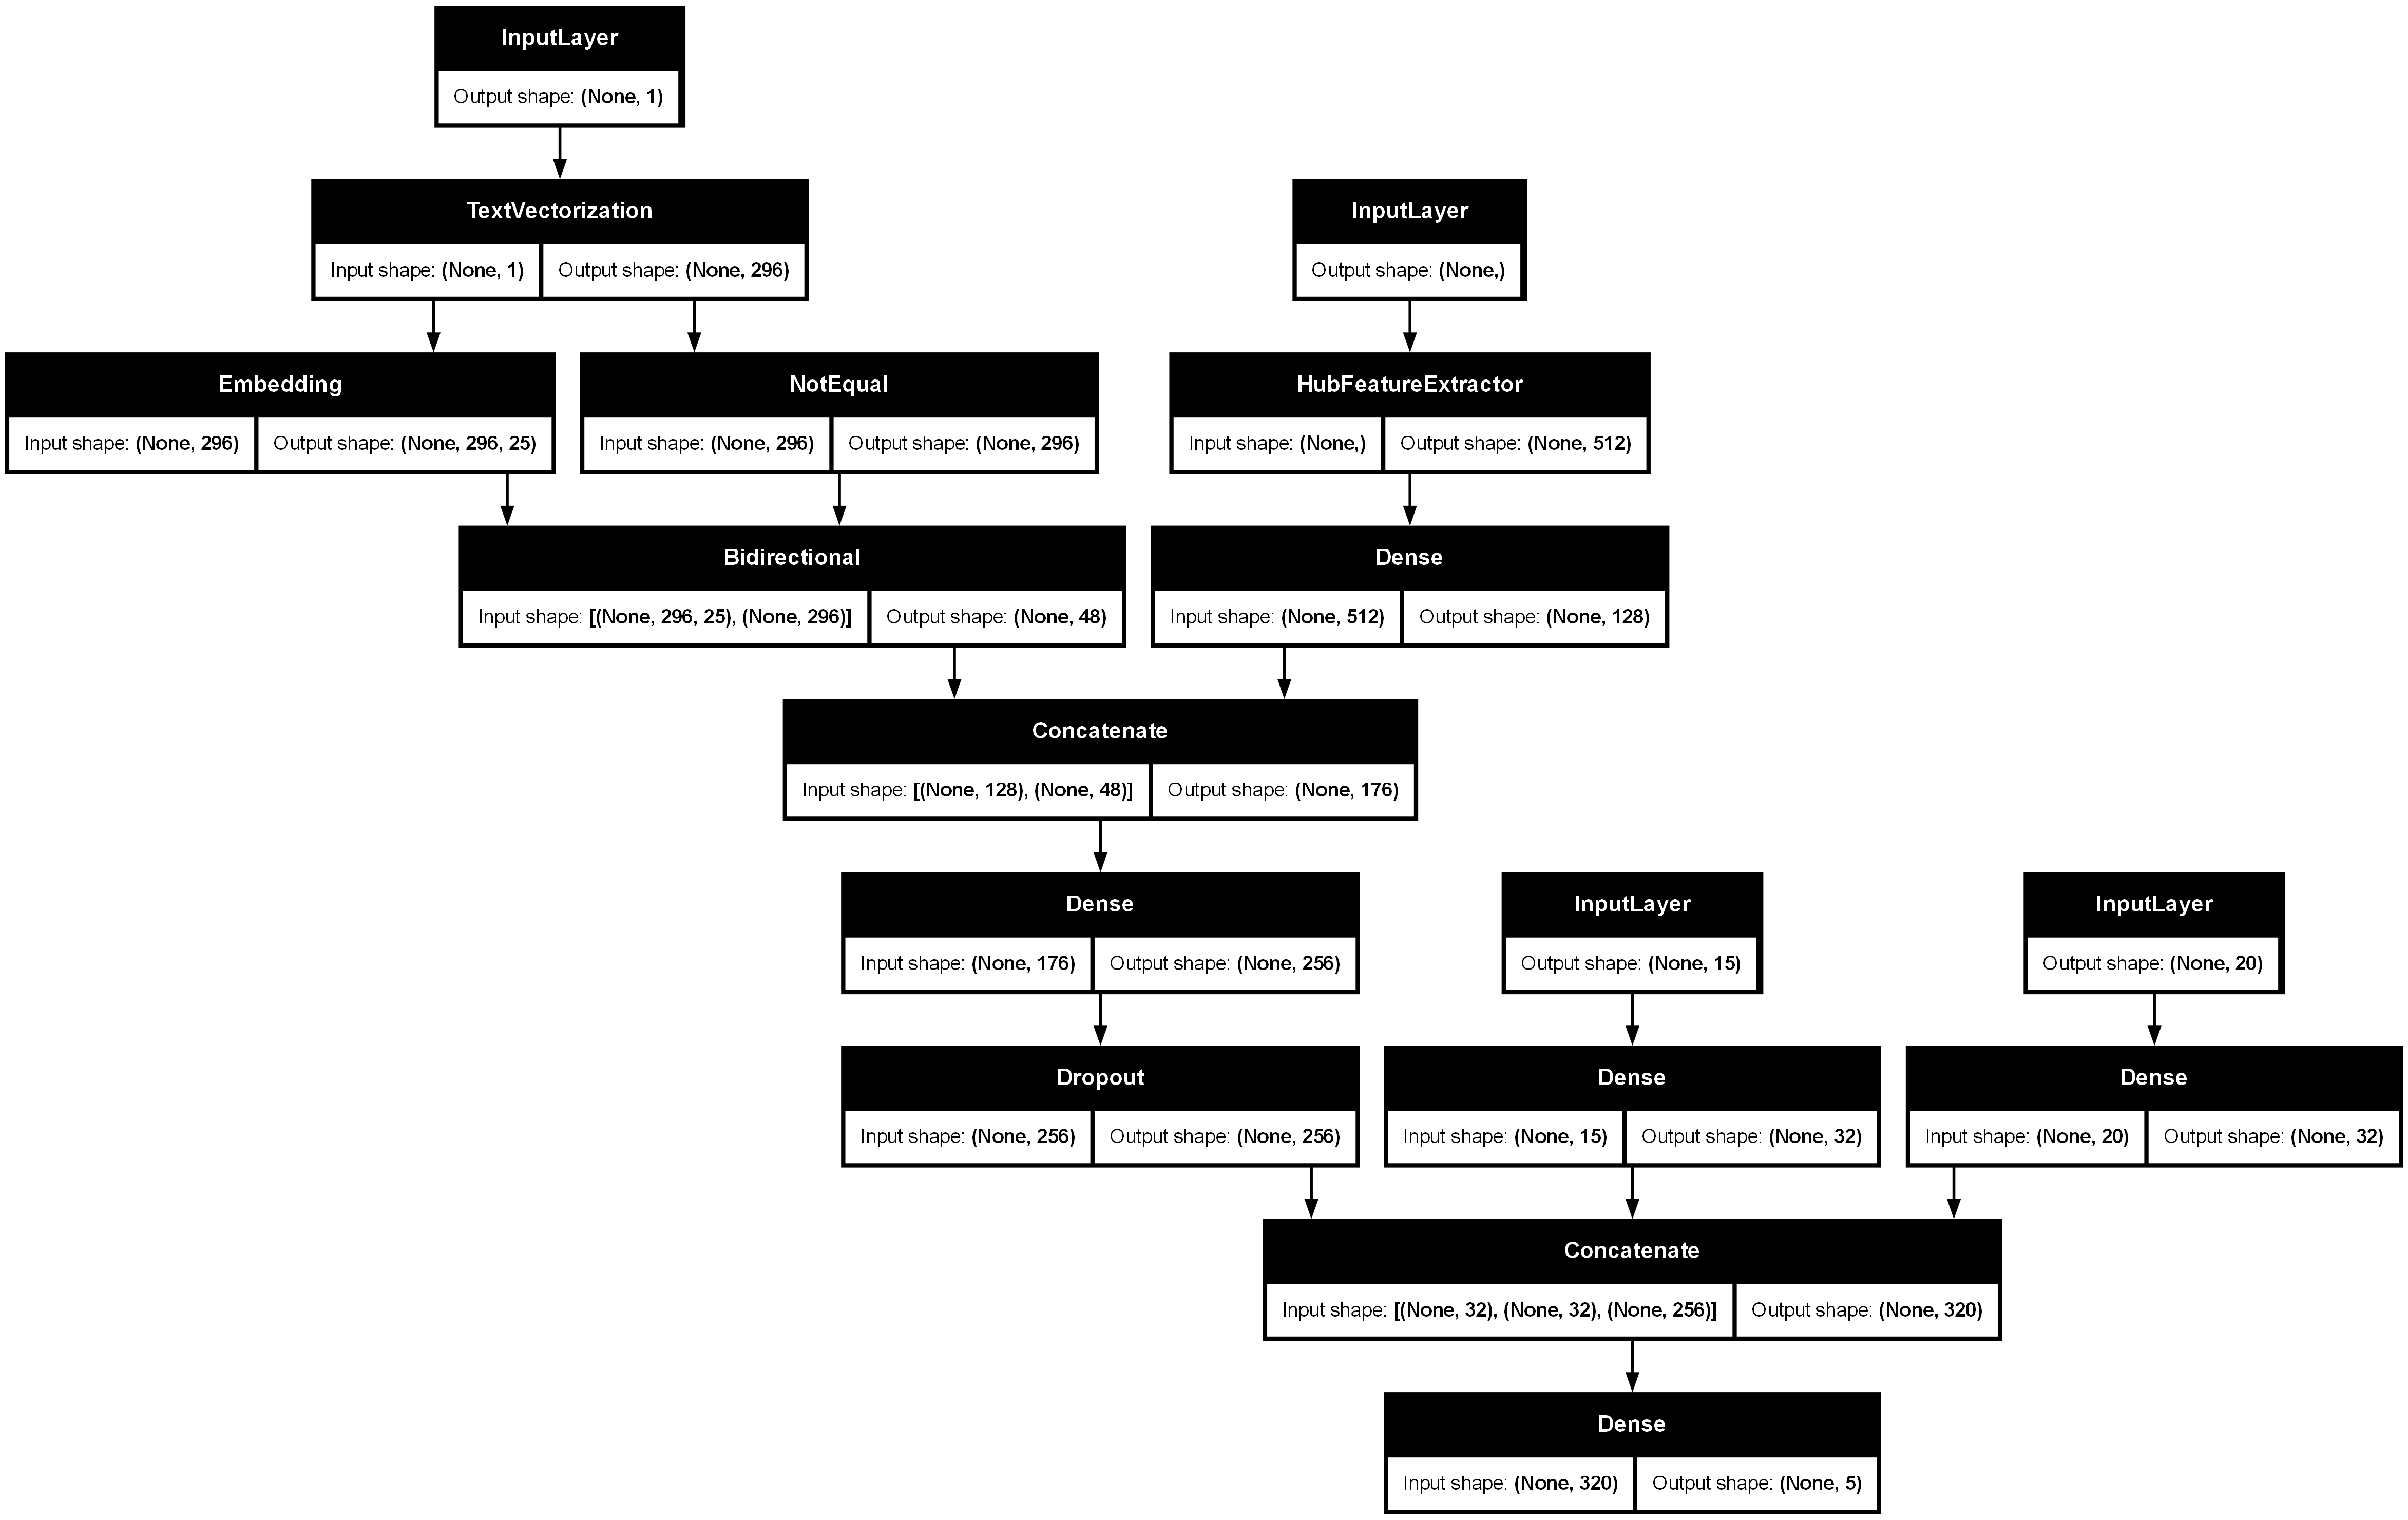

In [53]:
# Plot model_5 to explore it visually...
from tensorflow.keras.utils import plot_model
plot_model(model_5, show_shapes = True)

In [54]:
# Compile token, char, and positional embedding model
model_5.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2), # Label smoothing helps to prevent overfitting
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

### Create Tribrid Embedding Datasets Using tf.data:

In [39]:
# Create training and validation datasets (with all four kinds of input data)
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Do the same as above but for the validation dataset
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [56]:
# Check input shapes
train_char_token_pos_dataset, val_char_token_pos_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting, Evaluating, And Making Predictions With Our Tribrid Model:

In [57]:
# Fit our tribrid embedding model
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                             steps_per_epoch = int(0.1 * len(train_char_token_pos_dataset)),
                             epochs = 3,
                             validation_data = val_char_token_pos_dataset,
                             validation_steps = int(0.1 * len(val_char_token_pos_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 154s 256ms/step - accuracy: 0.7255 - loss: 1.0853 - val_accuracy: 0.8035 - val_loss: 0.9794
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 156s 277ms/step - accuracy: 0.8191 - loss: 0.9603 - val_accuracy: 0.8248 - val_loss: 0.9470
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 159s 283ms/step - accuracy: 0.8285 - loss: 0.9426 - val_accuracy: 0.8361 - val_loss: 0.9338


In [58]:
# Save model_5 and its history
save_model_and_history(model_5, history_model_5, 'model_5')

✅ Saved model to SkimLit_Models\model_5.keras
✅ Saved full History object to SkimLit_Models\model_5_history.pkl


In [5]:
# Load model_5 and its history
model_5, history_model_5 = load_model_and_history('model_5')

✅ Loaded model from SkimLit_Models\model_5.keras
✅ Loaded History object from SkimLit_Models\model_5_history.pkl


In [60]:
# Make predictions with the char token pos model
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset, verbose = 1)
model_5_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 186s 196ms/step


array([[0.5075564 , 0.10313726, 0.00921101, 0.35741892, 0.02267639],
       [0.54265875, 0.0967285 , 0.0432818 , 0.3010148 , 0.01631607],
       [0.29139632, 0.15350156, 0.10872524, 0.3933395 , 0.05303735],
       ...,
       [0.02939543, 0.10976321, 0.04535637, 0.02648535, 0.7889997 ],
       [0.03259671, 0.23406179, 0.06812862, 0.02959595, 0.63561696],
       [0.20576027, 0.55477476, 0.13535614, 0.0428578 , 0.06125108]],
      shape=(30212, 5), dtype=float32)

In [61]:
# Convert pred probs to pred labels
model_5_preds = tf.argmax(model_5_pred_probs, axis = 1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1], shape=(30212,))>

In [62]:
# Calculate results of char token pos model
model_5_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_5_preds)
model_5_results

{'accuracy': 83.86402753872633,
 'precision': 0.8375638151511854,
 'recall': 0.8386402753872634,
 'f1': 0.8375275540213575}

In [63]:
model_4_results

{'accuracy': 74.22547332185886,
 'precision': 0.7453455956008004,
 'recall': 0.7422547332185886,
 'f1': 0.7402384328463105}

In [64]:
# Save model_5 results
import pickle
with open('SkimLit_Models/model_5_results.pkl', 'wb') as f:
    pickle.dump(model_5_results, f)

In [41]:
# Load model_5 results
import pickle
with open('SkimLit_Models/model_5_results.pkl', 'rb') as f:
    model_5_results = pickle.load(f)

## Compare Model Results:

In [66]:
# Combine model results into a dataframe
all_model_results = pd.DataFrame({'model_0_baseline': baseline_results,
                                  'model_1_custom_token_embedding': model_1_results,
                                  'model_2_pretrained_token_embedding': model_2_results,
                                  'model_3_custom_char_embedding': model_3_results,
                                  'model_4_hybrid_char_token_embedding': model_4_results,
                                  'model_5_pos_char_token_embedding': model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,73.172911,0.731517,0.731729,0.705806
model_1_custom_token_embedding,79.038131,0.784963,0.790381,0.786738
model_2_pretrained_token_embedding,72.405005,0.723229,0.724050,0.719578
model_3_custom_char_embedding,64.351913,0.651942,0.643519,0.627208
model_4_hybrid_char_token_embedding,74.225473,0.745346,0.742255,0.740238
model_5_pos_char_token_embedding,83.864028,0.837564,0.838640,0.837528


In [67]:
# Reduce the accuracy to same scale as other metrics
all_model_results['accuracy'] = all_model_results['accuracy'] / 100

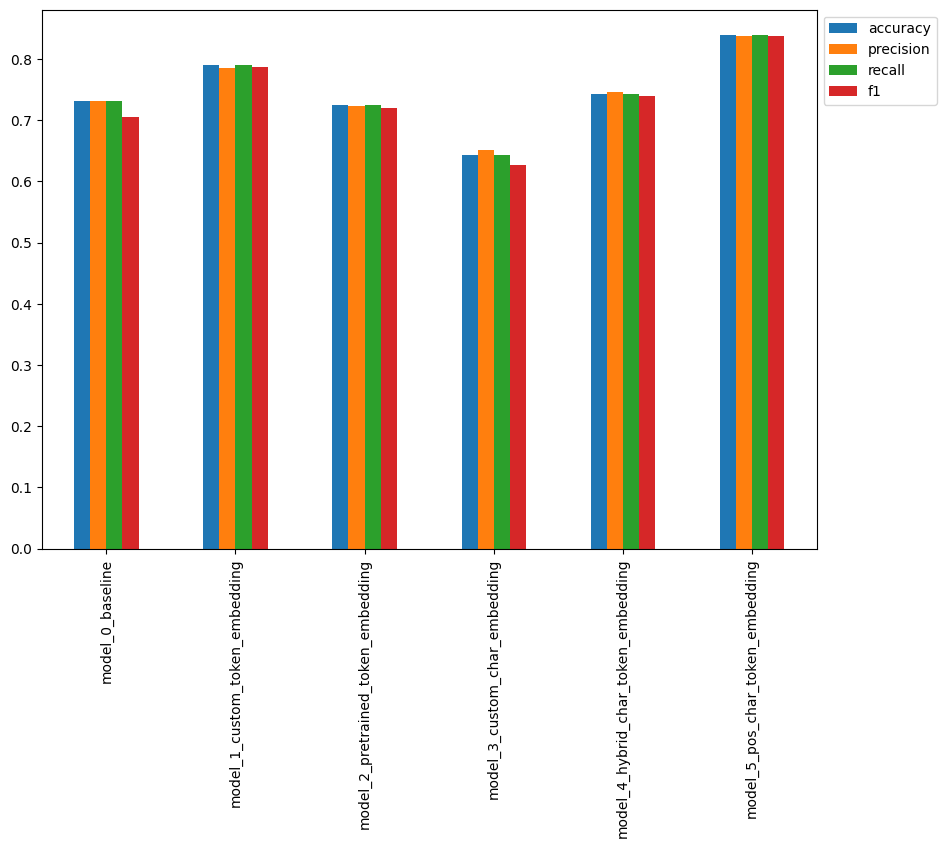

In [68]:
# Plot and compare all model results
all_model_results.plot(kind = 'bar', figsize = (10, 7)).legend(bbox_to_anchor = (1.0, 1.0));

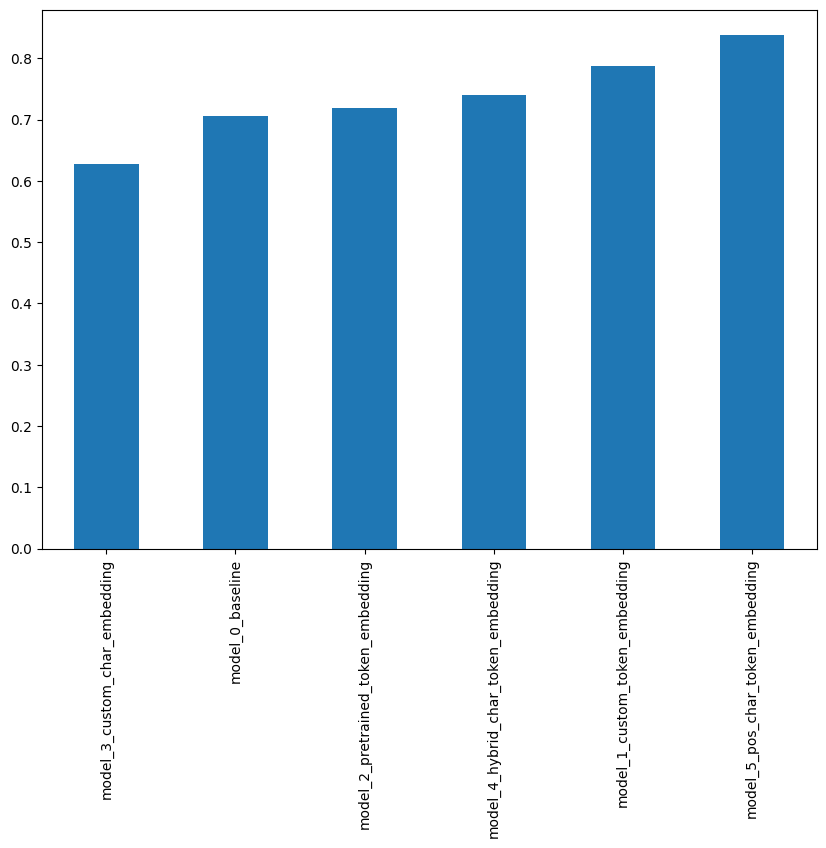

In [69]:
# Sort models' results by f1-score
all_model_results.sort_values('f1', ascending = True)['f1'].plot(kind = 'bar', figsize = (10, 7));

## Save And Load Model:

In [71]:
# Save the best performing model to keras format (default)
model_5.save('skimlit_tribrid_model.keras')

In [72]:
# Load in best performing model
loaded_model = tf.keras.models.load_model('skimlit_tribrid_model.keras')

In [76]:
# Make predictions with the loaded model on the validation set
loaded_pred_probs = loaded_model.predict(val_char_token_pos_dataset)
loaded_preds = tf.argmax(loaded_pred_probs, axis = 1)
loaded_preds[:10]

945/945 ━━━━━━━━━━━━━━━━━━━━ 224s 232ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [77]:
# Calculate the results of our loaded model
loaded_model_results = calculate_results(y_true = val_labels_encoded,
                                         y_pred = loaded_preds)
loaded_model_results

{'accuracy': 83.86402753872633,
 'precision': 0.8375638151511854,
 'recall': 0.8386402753872634,
 'f1': 0.8375275540213575}

In [75]:
model_5_results

{'accuracy': 83.86402753872633,
 'precision': 0.8375638151511854,
 'recall': 0.8386402753872634,
 'f1': 0.8375275540213575}

In [78]:
assert model_5_results == loaded_model_results

In [79]:
# Check the loaded model summary
loaded_model.summary()

Model: "model_5_tribrid_embedding_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ char_inputs         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_inputs        │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_vectorizer     │ (None, 296)       │          0 │ char_inputs[0][0] │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hub_feature_extrac… │ (None, 512)       │          0 │ token_inputs[0][… │
│ (HubFeatureExtract… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_embed          │ (None, 296, 25)   │        950 │ char_vectorizer[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_6         │ (None, 296)       │          0 │ char_vectorizer[… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     65,664 │ hub_feature_extr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 48)        │      9,600 │ char_embed[0][0], │
│ (Bidirectional)     │                   │            │ not_equal_6[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_token_hybrid_… │ (None, 176)       │          0 │ dense[0][0],      │
│ (Concatenate)       │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ line_number_input   │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ total_lines_input   │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │     45,312 │ char_token_hybri… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │        512 │ line_number_inpu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │        672 │ total_lines_inpu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_token_positio… │ (None, 320)       │          0 │ dense_1[0][0],    │
│ (Concatenate)       │                   │            │ dense_2[0][0],    │
│                     │                   │            │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 5)         │      1,605 │ char_token_posit… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 372,947 (1.42 MB)

 Trainable params: 124,315 (485.61 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 248,632 (971.22 KB)

## Your Challenges:

1. Turn the test data samples into a tf.data Dataset (fast loading) and then evaluate (make predictions) the best performing model on the test samples.
2. Find the most wrong predictions from 1 (these are the samples where the model has predicted the wrong label with the highest prediction probability).
3. Make example predictions (on RCT abstracts from the wild); you can go to PubMed to find these: https://pubmed.ncbi.nlm.nih.gov/; find and use our model to predict on 3-4 different abstracts from the wild.
    * Some examples: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/skimlit_example_abstracts.json

### Challenge 1 - Evaluating Model 5 On The Test Data:

In [42]:
# Create test dataset (with all four kinds of input data)
test_char_token_pos_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_pos_dataset = tf.data.Dataset.zip((test_char_token_pos_data, test_char_token_pos_labels))
test_char_token_pos_dataset = test_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Evaluate model_5 on the test dataset
model_5.evaluate(test_char_token_pos_dataset)

942/942 ━━━━━━━━━━━━━━━━━━━━ 175s 178ms/step - accuracy: 0.8344 - loss: 0.9375


[0.9375492334365845, 0.8344117999076843]

In [43]:
# Make predictions on the test dataset
model_5_pred_probs_test = model_5.predict(test_char_token_pos_dataset)
model_5_pred_probs_test

942/942 ━━━━━━━━━━━━━━━━━━━━ 146s 152ms/step


array([[0.3418878 , 0.07751234, 0.0283354 , 0.4924372 , 0.05982727],
       [0.34407175, 0.07320993, 0.19543946, 0.3401458 , 0.04713311],
       [0.0827181 , 0.02796279, 0.6843491 , 0.09906895, 0.10590109],
       ...,
       [0.05352439, 0.06524485, 0.08991123, 0.05546264, 0.73585695],
       [0.05971818, 0.07109955, 0.08636049, 0.05085001, 0.73197174],
       [0.06794621, 0.54766184, 0.12630029, 0.05372128, 0.20437038]],
      shape=(30135, 5), dtype=float32)

In [44]:
# Convert pred probs to labels
model_5_preds_test = tf.argmax(model_5_pred_probs_test, axis = 1)
model_5_preds_test

<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([3, 0, 2, ..., 4, 4, 1], shape=(30135,))>

In [45]:
# Calculate test results
model_5_results_test = calculate_results(y_true = test_labels_encoded,
                                         y_pred = model_5_preds_test)
model_5_results_test

{'accuracy': 83.441181350589,
 'precision': 0.8333364805006344,
 'recall': 0.8344118135058901,
 'f1': 0.8333972363138874}

In [48]:
# Save model_5 test results
import pickle
with open('SkimLit_Models/model_5_results_test.pkl', 'wb') as f:
    pickle.dump(model_5_results_test, f)

In [49]:
# Load model_5 test results
import pickle
with open('SkimLit_Models/model_5_results_test.pkl', 'rb') as f:
    model_5_results_test = pickle.load(f)

### Challenge 2 - Finding The Most Wrong Predictions From The Test Dataset:

In [51]:
test_df_conf = pd.DataFrame({'text': test_sentences,
                             'target': test_labels_encoded,
                             'pred': model_5_preds_test,
                             'pred_prob': model_5_pred_probs_test.max(axis = 1)})
test_df_conf.head()

,text,target,pred,pred_prob
0,this study analyzed liver function abnormaliti...,0,3,0.492437
1,a post hoc analysis was conducted with the use...,4,0,0.344072
2,liver function tests ( lfts ) were measured at...,4,2,0.684349
3,survival analyses were used to assess the asso...,4,4,0.428734
4,the percentage of patients with abnormal lfts ...,4,4,0.668167


In [ ]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = test_df_conf[test_df_conf['target'] != test_df_conf['pred']].sort_values('pred_prob', ascending = False)
most_wrong[:10]

,text,target,pred,pred_prob
2388,the primary endpoint is the cumulative three-y...,4,2,0.940297
8545,pretest-posttest .,2,0,0.939918
13874,symptom outcomes will be assessed and estimate...,1,2,0.932281
13598,-1.5 % vs. fish : -1.4 % vs. fish + s : -0.7 %...,2,4,0.914048
16347,to evaluate the effects of the lactic acid bac...,0,3,0.913908
4593,this study provides class ii evidence that reg...,2,1,0.912923
16633,clinicaltrials.gov identifier : nct01008475 .,1,0,0.909235
835,to assess the temporal patterns of late gastro...,0,3,0.901868
9468,pdt was associated with a significant decrease...,1,4,0.901313
15697,family practices were randomly assigned to rec...,4,2,0.898192


In [53]:
most_wrong.tail()

,text,target,pred,pred_prob
19985,storeowners agreed to pass on the discount to ...,2,1,0.242467
19096,the primary purpose of our study is to examine...,2,1,0.240930
26966,this study assessed the efficacy of low intens...,0,1,0.240537
7066,generalized linear models indicated seeking sa...,4,0,0.236127
29506,risk factors known to increase the risk of non...,4,0,0.227035


In [54]:
# Visualize the wrong predictions with the highest confidence
for row in most_wrong[:10].itertuples():
    _, text, target, pred, pred_prob = row
    print(f'Target: {target}, Pred: {pred}, Prob: {pred_prob}')
    print(f'Text:\n{text}\n')
    print('----\n')

Target: 4, Pred: 2, Prob: 0.9402967095375061
Text:
the primary endpoint is the cumulative three-year hiv incidence .

----

Target: 2, Pred: 0, Prob: 0.9399183988571167
Text:
pretest-posttest .

----

Target: 1, Pred: 2, Prob: 0.9322811365127563
Text:
symptom outcomes will be assessed and estimates of cost-effectiveness made .

----

Target: 2, Pred: 4, Prob: 0.9140484929084778
Text:
-1.5 % vs. fish : -1.4 % vs. fish + s : -0.7 % ; p < 0.001 ) but there were no significant differences between groups .

----

Target: 0, Pred: 3, Prob: 0.9139078259468079
Text:
to evaluate the effects of the lactic acid bacterium lactobacillus salivarius on caries risk factors .

----

Target: 2, Pred: 1, Prob: 0.9129225611686707
Text:
this study provides class ii evidence that regular aerobic training with or without postexercise protein-carbohydrate supplementation improves fitness and workload in patients with fshd .

----

Target: 1, Pred: 0, Prob: 0.9092350602149963
Text:
clinicaltrials.gov identifie

In [55]:
# Visualize the wrong predictions with the lowest confidence
for row in most_wrong[-10:].itertuples():
    _, text, target, pred, pred_prob = row
    print(f'Target: {target}, Pred: {pred}, Prob: {pred_prob}')
    print(f'Text:\n{text}\n')
    print('----\n')

Target: 2, Pred: 3, Prob: 0.24744491279125214
Text:
we examined the frequency of experiencing situations involving weight stigma and consciousness of weight stigma in relation to hypothalamic -- pituitary -- adrenal axis activity and oxidative stress ( f-isoprostanes ) in 45 healthy overweight to obese women .

----

Target: 3, Pred: 0, Prob: 0.24661728739738464
Text:
we hypothesized that increased hypoxic chemosensitivity in men could be associated with the development of nocturnal periodic breathing at altitude more frequently than in women , and that acetazolamide , by leftward shifting the co2 ventilatory response , could improve nocturnal periodic breathing at altitude in a sex-independent manner .

----

Target: 0, Pred: 1, Prob: 0.24621230363845825
Text:
the aim of this study is to determine whether a web-based treatment program for patients with eating disorders can improve eating disorder psychopathology among female patients with bulimia nervosa , binge eating disorder and ea

### Challenge 3 - Predicting On External PubMed RCT Abstracts:

In [6]:
import json
import nltk

# Make sure you have the punkt tokenizer
nltk.download('punkt')
nltk.download('punkt_tab')

def preprocess_json_with_line_numbers(filename):
    """
    Reads a JSON file of abstracts and returns a list of dictionaries
    with sentence-level data: target label (placeholder), text, line number,
    and total lines in the abstract.
    """
    abstract_samples = []

    with open(filename, "r", encoding="utf-8") as f:
        data = json.load(f)  # list of dicts with 'abstract', 'source', 'details'

    for entry in data:
        abstract_text = entry["abstract"]
        # Split into sentences (use nltk for robust splitting)
        sentences = nltk.sent_tokenize(abstract_text)

        for line_number, sentence in enumerate(sentences):
            line_data = {
                "target": "UNK",  # placeholder since JSON lacks labels
                "text": sentence.lower().strip(),
                "line_number": line_number,
                "total_lines": len(sentences) - 1,
                "source": entry.get("source", None),
                "details": entry.get("details", None)
            }
            abstract_samples.append(line_data)

    return abstract_samples

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jake\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Jake\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [7]:
# Read external PubMed RCT Abstracts from Json File:
external_samples = preprocess_json_with_line_numbers('skimlit_example_abstracts.json')
len(external_samples)

41

In [8]:
external_samples

[{'target': 'UNK',
  'text': 'this rct examined the efficacy of a manualized social intervention for children with hfasds.',
  'line_number': 0,
  'total_lines': 7,
  'source': 'https://pubmed.ncbi.nlm.nih.gov/20232240/',
  'details': 'RCT of a manualized social treatment for high-functioning autism spectrum disorders'},
 {'target': 'UNK',
  'text': 'participants were randomly assigned to treatment or wait-list conditions.',
  'line_number': 1,
  'total_lines': 7,
  'source': 'https://pubmed.ncbi.nlm.nih.gov/20232240/',
  'details': 'RCT of a manualized social treatment for high-functioning autism spectrum disorders'},
 {'target': 'UNK',
  'text': 'treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
  'line_number': 2,
  'total_lines': 7,
  'source': 'https://pubmed.ncbi.nlm.nih.gov/20232240/',
  'details': 'RCT of a manualized social treatment for high-functioning

In [ ]:
# Turn external samples into a Pandas DataFrame
external_df = pd.DataFrame(external_samples)
external_df.head(7)

,target,text,line_number,total_lines,source,details
0,UNK,this rct examined the efficacy of a manualized...,0,7,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,UNK,participants were randomly assigned to treatme...,1,7,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
2,UNK,treatment included instruction and therapeutic...,2,7,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
3,UNK,a response-cost program was applied to reduce ...,3,7,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
4,UNK,significant treatment effects were found for f...,4,7,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
5,UNK,secondary measures based on staff ratings (tre...,5,7,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
6,UNK,"high levels of parent, child and staff satisfa...",6,7,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...


In [20]:
# Convert abstract text lines into lists
external_sentences = external_df['text'].tolist()
len(external_sentences)

41

In [21]:
# Split sentences into characters
def split_chars(text):
    return ' '.join(list(text))

external_chars = [split_chars(sentence) for sentence in external_sentences]
external_chars[:7]

['t h i s   r c t   e x a m i n e d   t h e   e f f i c a c y   o f   a   m a n u a l i z e d   s o c i a l   i n t e r v e n t i o n   f o r   c h i l d r e n   w i t h   h f a s d s .',
 'p a r t i c i p a n t s   w e r e   r a n d o m l y   a s s i g n e d   t o   t r e a t m e n t   o r   w a i t - l i s t   c o n d i t i o n s .',
 't r e a t m e n t   i n c l u d e d   i n s t r u c t i o n   a n d   t h e r a p e u t i c   a c t i v i t i e s   t a r g e t i n g   s o c i a l   s k i l l s ,   f a c e - e m o t i o n   r e c o g n i t i o n ,   i n t e r e s t   e x p a n s i o n ,   a n d   i n t e r p r e t a t i o n   o f   n o n - l i t e r a l   l a n g u a g e .',
 'a   r e s p o n s e - c o s t   p r o g r a m   w a s   a p p l i e d   t o   r e d u c e   p r o b l e m   b e h a v i o r s   a n d   f o s t e r   s k i l l s   a c q u i s i t i o n .',
 's i g n i f i c a n t   t r e a t m e n t   e f f e c t s   w e r e   f o u n d   f o r   f i v e   o f   s e v e n   p 

In [22]:
# Get line number and total lines embeddings for the external data
external_line_numbers_one_hot = tf.one_hot(external_df['line_number'].to_numpy(), depth = 15)
external_total_lines_one_hot = tf.one_hot(external_df['total_lines'].to_numpy(), depth = 20)
external_line_numbers_one_hot.shape, external_total_lines_one_hot.shape

(TensorShape([41, 15]), TensorShape([41, 20]))

In [27]:
# Create fast-loading external dataset
external_char_token_pos_dataset = tf.data.Dataset.from_tensor_slices({
    "line_number_input": external_line_numbers_one_hot,
    "total_lines_input": external_total_lines_one_hot,
    "token_inputs": external_sentences,
    "char_inputs": external_chars
}).batch(32).prefetch(tf.data.AUTOTUNE)

In [28]:
# Make predictions on external dataset
model_5_pred_probs_external = model_5.predict(external_char_token_pos_dataset)
model_5_pred_probs_external

2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step


array([[0.2965674 , 0.08936153, 0.01604239, 0.5710251 , 0.02700355],
       [0.06578087, 0.02506592, 0.7799231 , 0.0889633 , 0.0402669 ],
       [0.14738028, 0.04899094, 0.51529855, 0.19557774, 0.09275252],
       [0.10927329, 0.16447583, 0.5191859 , 0.0899993 , 0.11706563],
       [0.05113058, 0.06461875, 0.46882758, 0.04802424, 0.36739886],
       [0.04027925, 0.09403463, 0.46474364, 0.05084434, 0.35009816],
       [0.03428442, 0.13367026, 0.09984317, 0.02808426, 0.70411783],
       [0.01869717, 0.11678462, 0.29547408, 0.033168  , 0.5358763 ],
       [0.3904454 , 0.04637949, 0.04863172, 0.43572187, 0.07882155],
       [0.43276715, 0.08216941, 0.07407859, 0.32091862, 0.09006623],
       [0.32414344, 0.16969474, 0.18580306, 0.28480554, 0.03555322],
       [0.1176347 , 0.12585689, 0.5610689 , 0.10723694, 0.08820256],
       [0.11131134, 0.15118794, 0.25349203, 0.10477995, 0.3792288 ],
       [0.07898047, 0.24750747, 0.12575608, 0.07581119, 0.47194472],
       [0.06705066, 0.27997583, 0.

In [29]:
# Convert pred probs into labels
model_5_preds_external = tf.argmax(model_5_pred_probs_external, axis = 1)
model_5_preds_external

<tf.Tensor: shape=(41,), dtype=int64, numpy=
array([3, 2, 2, 2, 2, 2, 4, 4, 3, 0, 0, 2, 4, 4, 2, 4, 1, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 2, 3, 2, 4, 2, 4, 4, 1, 1, 1])>

In [30]:
# Create labeled dataframe of the external samples
external_df_labeled = external_df.copy(deep = True)
external_df_labeled['target'] = model_5_preds_external
external_df_labeled

,target,text,line_number,total_lines,source,details
0,3,this rct examined the efficacy of a manualized...,0,7,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,2,participants were randomly assigned to treatme...,1,7,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
2,2,treatment included instruction and therapeutic...,2,7,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
3,2,a response-cost program was applied to reduce ...,3,7,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
4,2,significant treatment effects were found for f...,4,7,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
5,2,secondary measures based on staff ratings (tre...,5,7,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
6,4,"high levels of parent, child and staff satisfa...",6,7,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
7,4,standardized effect size estimates were primar...,7,7,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
8,3,postpartum depression (ppd) is the most preval...,0,9,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
9,0,"no single cause of ppd has been identified, ho...",1,9,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
